In [1]:
library(ggplot2)
library(tidyverse)
library(data.table)
source('utils/helper.R')
source("utils/summary_utils.R")

Warning message:
"package 'ggplot2' was built under R version 4.4.3"
Warning message:
"package 'tidyverse' was built under R version 4.4.3"
Warning message:
"package 'tibble' was built under R version 4.4.2"
Warning message:
"package 'tidyr' was built under R version 4.4.3"
Warning message:
"package 'readr' was built under R version 4.4.3"
Warning message:
"package 'purrr' was built under R version 4.4.3"
Warning message:
"package 'dplyr' was built under R version 4.4.3"
Warning message:
"package 'stringr' was built under R version 4.4.2"
Warning message:
"package 'forcats' was built under R version 4.4.3"
Warning message:
"package 'lubridate' was built under R version 4.4.3"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
── Conflicts ─────────────────────

### Data PreProcessing

In [4]:
human_dynamic = read.csv('../human_data/merged_dynamic.csv') ## 97 subjects
human_static = read.csv("../human_data/merged_static.csv") ## 387 subjects
human_combined = rbind(human_dynamic, human_static)
human_combined$X = NULL
colnames(human_combined) = c("choice", "outcome", "subjID", "block", "schedule_type")

In [6]:
gpt_data = read.csv('../img_data/img_gpt_4_vision.csv')
gpt_data$X = NULL
colnames(gpt_data) = c("subjID", "trial", "choice", "outcome", "probsX", "probsY")
gpt_data$subjID <- paste(gpt_data$subjID, "gpt-4", sep="-")

In [8]:
gemini_data = read.csv('../img_data/img_gemini.csv')
gemini_data$X = NULL
colnames(gemini_data) = c("subjID", "trial", "choice", "outcome", "probsX", "probsY")
gemini_data$subjID <- paste(gemini_data$subjID, "gemini", sep="-")

### Reward

In [11]:
## reward
human_reward_sum <- human_combined %>%
  group_by(subjID) %>%
  summarise(reward = sum(outcome, na.rm = TRUE))
human_reward_sum['subject'] = "Human"

In [13]:
gpt_reward_sum <- gpt_data %>%
  group_by(subjID) %>%
  summarise(reward = sum(outcome, na.rm = TRUE))
gpt_reward_sum['subject'] = "GPT-4"

In [15]:
gemini_reward_sum <- gemini_data %>%
  group_by(subjID) %>%
  summarise(reward = sum(outcome, na.rm = TRUE))
gemini_reward_sum['subject'] = "gemini"

In [17]:
reward_sum = rbind(human_reward_sum, gpt_reward_sum, gemini_reward_sum)

In [21]:
## percentage of choosing each option
human_choice_counts <- human_combined %>%
  group_by(subjID) %>%
  summarise(X = sum(choice == "0"),
            Y = sum(choice == "1"))

GPT_choice_counts <- gpt_data %>% 
  group_by(subjID) %>% 
  summarise(X = sum(choice == "0"),
            Y = sum(choice == "1"))
GEMINI_choice_counts <- gemini_data %>% 
  group_by(subjID) %>% 
  summarise(X = sum(choice == "0"),
            Y = sum(choice == "1"))

choice_counts = rbind(human_choice_counts, GPT_choice_counts, GEMINI_choice_counts)

In [25]:
## shift rate
human_table <- as.data.table(human_combined)
human_list = frame2list(human_table)
human_shift = loss_shift_fun(human_list)
human_df = data.frame(subjID = unique(human_table$subjID),
                      loss_shift = human_shift$loss_mean_sub, 
                      reward_shift = human_shift$reward_mean_sub)

GPT_table <- as.data.table(gpt_data)
GPT_list = frame2list(GPT_table)
GPT_shift = loss_shift_fun(GPT_list)
GPT_df = data.frame(subjID = unique(GPT_table$subjID),
                      loss_shift = GPT_shift$loss_mean_sub, 
                      reward_shift = GPT_shift$reward_mean_sub)

GEMINI_table <- as.data.table(gemini_data)
GEMINI_list = frame2list(GEMINI_table)
GEMINI_shift = loss_shift_fun(GEMINI_list)
GEMINI_df = data.frame(subjID = unique(GEMINI_table$subjID),
                    loss_shift = GEMINI_shift$loss_mean_sub, 
                    reward_shift = GEMINI_shift$reward_mean_sub)

shift = rbind(human_df, GPT_df, GEMINI_df)
merged_df = merge(reward_sum, choice_counts,  by="subjID")
merged_df = merge(merged_df, shift,  by="subjID")

In [27]:
merged_df

subjID,reward,subject,X,Y,loss_shift,reward_shift
<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>
1-gemini,23,gemini,21,79,0.3552632,0.4347826
1-gpt-4,24,GPT-4,22,78,0.3200000,0.2083333
10-gemini,25,gemini,22,78,0.4324324,0.4000000
10-gpt-4,24,GPT-4,26,74,0.3866667,0.4583333
100-gemini,20,gemini,19,81,0.3750000,0.2105263
100-gpt-4,18,GPT-4,19,81,0.2962963,0.2777778
101-gemini,23,gemini,21,79,0.3684211,0.1739130
101-gpt-4,29,GPT-4,19,81,0.2571429,0.2758621
102-gemini,32,gemini,29,71,0.3088235,0.3548387


## Plots

In [30]:
merged_df$subject <- recode(merged_df$subject,
                            "gemini" = "GEMINI",
                            "GPT-4" = "GPT-4",
                            "Human" = "Human")


Warning message:
"The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead."
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"Computation failed in `stat_summary()`.
Caused by error in `fun.data()`:
! The package "Hmisc" is required."


<ggproto object: Class ScaleDiscretePosition, ScaleDiscrete, Scale, gg>
    aesthetics: x xmin xmax xend
    axis_order: function
    break_info: function
    break_positions: function
    breaks: waiver
    call: call
    clone: function
    dimension: function
    drop: TRUE
    expand: waiver
    get_breaks: function
    get_breaks_minor: function
    get_labels: function
    get_limits: function
    get_transformation: function
    guide: waiver
    is_discrete: function
    is_empty: function
    labels: waiver
    limits: Human GPT-4 GEMINI
    make_sec_title: function
    make_title: function
    map: function
    map_df: function
    n.breaks.cache: NULL
    na.translate: TRUE
    na.value: NA
    name: waiver
    palette: function
    palette.cache: NULL
    position: bottom
    range: environment
    range_c: environment
    rescale: function
    reset: function
    train: function
    train_df: function
    transform: function
    transform_df: function
    super:  <ggproto 

List of 14
 $ text              :List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : chr "black"
  ..$ size         : num 10
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ axis.title.x      : list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 $ axis.title.y      :List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : chr "black"
  ..$ size         : num 20
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ axis.text         :List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : chr "bl

ERROR: [1m[33mError[39m in `ggsave()`:[22m
[1m[22m[33m![39m Cannot find directory [34mplots[39m.
[36mℹ[39m Please supply an existing directory or use `create.dir = TRUE`.


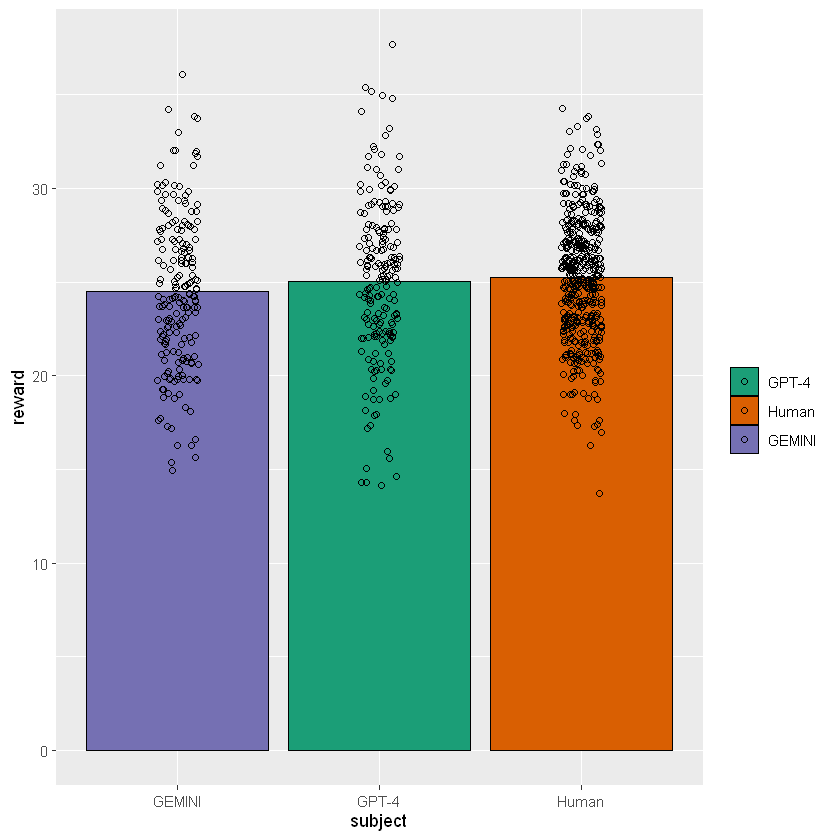

In [32]:
################## plot reward score for human and GPT ###########################
ggplot(merged_df, aes(x=subject, y=reward, fill=subject))+
  # geom_boxplot()+
  stat_summary(fun.y = "mean", geom = "bar", position = position_dodge(), color="black", size=0.2) +
  stat_summary(fun.data = mean_cl_normal, geom="linerange", colour=error_bar_colour,
               position=position_dodge(.9),  fun.args = list(mult = 1)) +
  # geom_point(color="black", position=position_nudge(x = -0.2, y = 0), alpha=0.5, size=1) +
  # geom_line(aes(group=subjID), alpha= 0.1, position=position_nudge(x = -0.2, y = 0), size=0.7) +
  
  geom_jitter(shape=1, position=position_jitter(0.1))+
  # scale_fill_brewer(name = "", palette="Dark2", limits=c("GPT-3.5", "Human", "GEMINI")) +
  # scale_x_discrete(limits = c("Human", "GPT-3.5", "GEMINI")) +
  scale_fill_brewer(name = "", palette="Dark2", limits=c("GPT-4", "Human", "GEMINI"))
  scale_x_discrete(limits = c("Human", "GPT-4", "GEMINI"))

  theme_no_legend_x_title()+
  # ggtitle(title) +
  ylab("Reward Rate%")+
  theme(axis.title.y = element_text(size = 20), # Increase Y-axis label size and make it bold
        axis.text.x = element_text(size = 16), # Increase X-axis tick text size
        axis.text.y = element_text(size = 16)) # Increase legend title size
ggsave("plots/reward_score.pdf", width=10, height=10, unit="cm", useDingbats=FALSE)

Warning message:
"Computation failed in `stat_summary()`.
Caused by error in `fun.data()`:
! The package "Hmisc" is required."


ERROR: [1m[33mError[39m in `ggsave()`:[22m
[1m[22m[33m![39m Cannot find directory [34mplots[39m.
[36mℹ[39m Please supply an existing directory or use `create.dir = TRUE`.


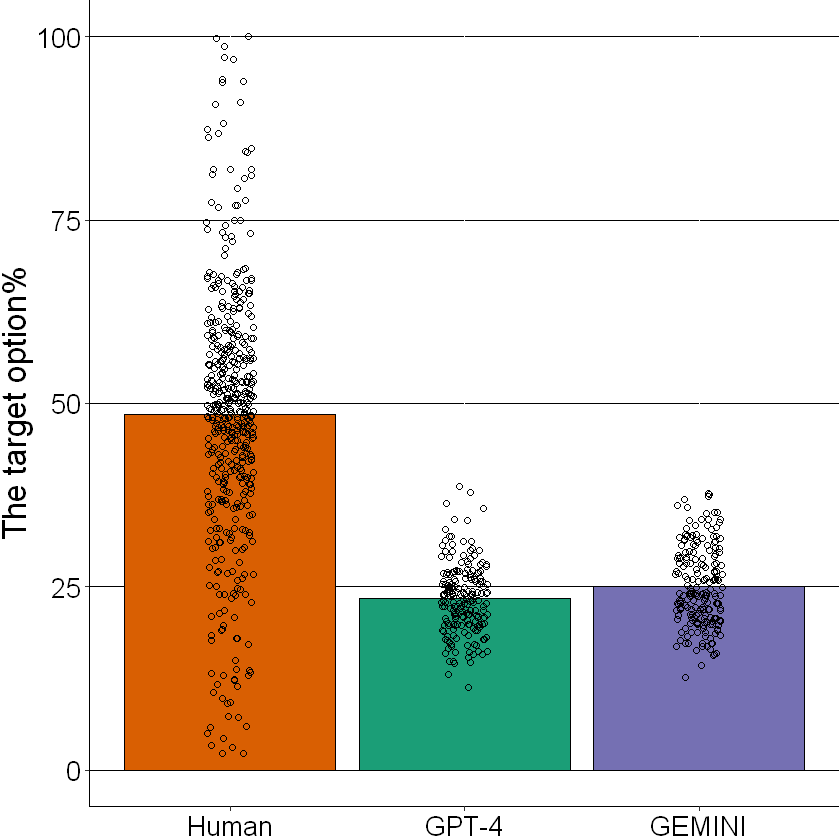

In [34]:
ggplot(merged_df, aes(x = subject, y = X, fill = subject)) +
  stat_summary(fun = mean, geom = "bar", position = position_dodge(), color = "black", size = 0.2) +
  stat_summary(fun.data = mean_cl_normal, geom = "linerange", colour = "black",
               position = position_dodge(0.9), fun.args = list(mult = 1)) +
  geom_jitter(shape = 1, position = position_jitter(0.1)) +
  scale_fill_brewer(name = "", palette = "Dark2", limits = c("GPT-4", "Human", "GEMINI")) +
  scale_x_discrete(limits = c("Human", "GPT-4", "GEMINI")) +
  theme_no_legend_x_title() +
  ylab("The target option%") +
  theme(axis.title.y = element_text(size = 20),
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16))

ggsave("plots/target_option.pdf", width = 10, height = 10, unit = "cm", useDingbats = FALSE)

Warning message:
"Computation failed in `stat_summary()`.
Caused by error in `fun.data()`:
! The package "Hmisc" is required."


ERROR: [1m[33mError[39m in `ggsave()`:[22m
[1m[22m[33m![39m Cannot find directory [34mplots[39m.
[36mℹ[39m Please supply an existing directory or use `create.dir = TRUE`.


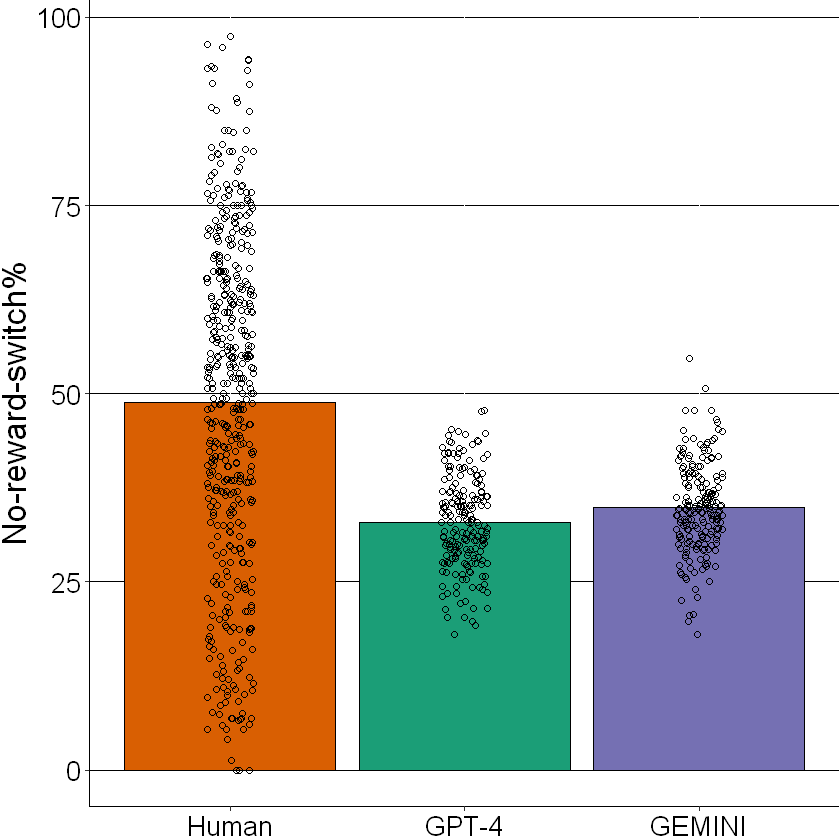

In [36]:
ggplot(merged_df, aes(x = subject, y = loss_shift * 100, fill = subject)) +
  stat_summary(fun = mean, geom = "bar", position = position_dodge(), color = "black", size = 0.2) +
  stat_summary(fun.data = mean_cl_normal, geom = "linerange", colour = "black",
               position = position_dodge(0.9), fun.args = list(mult = 1)) +
  geom_jitter(shape = 1, position = position_jitter(0.1)) +
  scale_fill_brewer(name = "", palette = "Dark2", limits = c("GPT-4", "Human", "GEMINI")) +
  scale_x_discrete(limits = c("Human", "GPT-4", "GEMINI")) +
  theme_no_legend_x_title() +
  ylab("No-reward-switch%") +
  theme(axis.title.y = element_text(size = 20),
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16))

ggsave("plots/loss_shift.pdf", width = 10, height = 10, unit = "cm", useDingbats = FALSE)


Warning message:
"Computation failed in `stat_summary()`.
Caused by error in `fun.data()`:
! The package "Hmisc" is required."


ERROR: [1m[33mError[39m in `ggsave()`:[22m
[1m[22m[33m![39m Cannot find directory [34mplots[39m.
[36mℹ[39m Please supply an existing directory or use `create.dir = TRUE`.


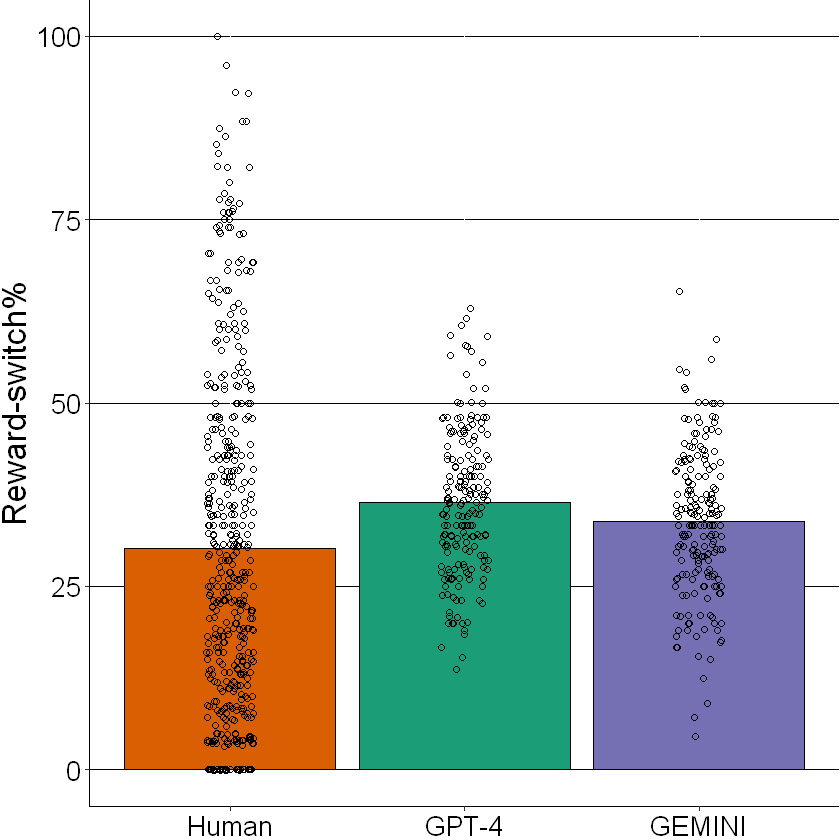

In [38]:
ggplot(merged_df, aes(x = subject, y = reward_shift * 100, fill = subject)) +
  stat_summary(fun = mean, geom = "bar", position = position_dodge(), color = "black", size = 0.2) +
  stat_summary(fun.data = mean_cl_normal, geom = "linerange", colour = "black",
               position = position_dodge(0.9), fun.args = list(mult = 1)) +
  geom_jitter(shape = 1, position = position_jitter(0.1)) +
  scale_fill_brewer(name = "", palette = "Dark2", limits = c("GPT-4", "Human", "GEMINI")) +
  scale_x_discrete(limits = c("Human", "GPT-4", "GEMINI")) +
  theme_no_legend_x_title() +
  ylab("Reward-switch%") +
  theme(axis.title.y = element_text(size = 20),
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16))

ggsave("plots/reward_shift.pdf", width = 10, height = 10, unit = "cm", useDingbats = FALSE)


## T test

In [43]:
############################ t-test ########################
result <- aov(reward ~ subject, data = merged_df)
summary(result)
TukeyHSD(aov(reward ~ subject, data = merged_df))

t.test(GPT_choice_counts$X, GPT_choice_counts$Y, paired = TRUE)
t.test(GEMINI_choice_counts$X, GEMINI_choice_counts$Y, paired = TRUE)

calculate_switches <- function(choices) {
  # Calculate changes in choices
  switches <- sum(diff(as.numeric(as.factor(choices))) != 0)
  return(switches)
}
consistency_index <- gemini_data %>%
  group_by(subjID) %>%
  summarise(
    Total_Switches = calculate_switches(choice),
    Trials = n(),
    Consistency_Index = 1 - (Total_Switches / (Trials - 1))  # Normalizing switches
  )
ggplot(consistency_index, aes(x = seq(1:99), y = Consistency_Index)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "Consistency Index Across Simulations", x = "Simulation ID", y = "Consistency Index")

result <- aov(loss_shift ~ subject, data = merged_df)
summary(result)
TukeyHSD(aov(loss_shift ~ subject, data = merged_df))

result <- aov(reward_shift ~ subject, data = merged_df)
summary(result)
TukeyHSD(aov(reward_shift ~ subject, data = merged_df))

write.csv(merged_df, '../sim_data_summarization.csv', row.names = FALSE)

             Df Sum Sq Mean Sq F value Pr(>F)  
subject       2     73   36.56   2.671 0.0697 .
Residuals   881  12058   13.69                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = reward ~ subject, data = merged_df)

$subject
                  diff         lwr       upr     p adj
GPT-4-GEMINI 0.5100000 -0.35853091 1.3785309 0.3526051
Human-GEMINI 0.7188017 -0.01128709 1.4488904 0.0547481
Human-GPT-4  0.2088017 -0.52128709 0.9388904 0.7801740



	Paired t-test

data:  GPT_choice_counts$X and GPT_choice_counts$Y
t = -80.015, df = 199, p-value < 2.2e-16
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -54.55209 -51.92791
sample estimates:
mean difference 
         -53.24 



	Paired t-test

data:  GEMINI_choice_counts$X and GEMINI_choice_counts$Y
t = -64.881, df = 199, p-value < 2.2e-16
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -51.41662 -48.38338
sample estimates:
mean difference 
          -49.9 


ERROR while rich displaying an object: Error in `geom_bar()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error in `check_aesthetics()`:
! Aesthetics must be either length 1 or the same as the data (200).
✖ Fix the following mappings: `x`.

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mim

             Df Sum Sq Mean Sq F value Pr(>F)    
subject       2  4.886  2.4429   86.36 <2e-16 ***
Residuals   881 24.922  0.0283                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = loss_shift ~ subject, data = merged_df)

$subject
                    diff         lwr        upr     p adj
GPT-4-GEMINI -0.01925511 -0.05874066 0.02023043 0.4867283
Human-GEMINI  0.13916585  0.10597422 0.17235748 0.0000000
Human-GPT-4   0.15842096  0.12522934 0.19161259 0.0000000


             Df Sum Sq Mean Sq F value   Pr(>F)    
subject       2   0.60 0.30015   8.914 0.000147 ***
Residuals   881  29.66 0.03367                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = reward_shift ~ subject, data = merged_df)

$subject
                    diff         lwr           upr     p adj
GPT-4-GEMINI  0.02509173 -0.01798825  0.0681717194 0.3585519
Human-GEMINI -0.03698799 -0.07320111 -0.0007748759 0.0440025
Human-GPT-4  -0.06207973 -0.09829285 -0.0258666096 0.0001830
